In [1]:
import time

import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_prepocessing import Dataset, BatchLoader

In [29]:
sns.set_theme()

%matplotlib inline

In [2]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
df = pd.DataFrame(data, columns=['text'])
df

,text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...
...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...
18843,From: westes@netcom.com (Will Estes)\nSubject:...
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...


In [61]:
df = pd.read_csv('./data/bbc_text_cls.csv')
maxlen = np.quantile(df.text.apply(len), q=0.99)
print(len(df))
df = df[df.text.apply(len) < maxlen].reset_index(drop=True)
df

2225


,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2197,TV's future down the phone line\n\nInternet TV...,tech
2198,Cebit fever takes over Hanover\n\nThousands of...,tech
2199,BT program to beat dialler scams\n\nBT is intr...,tech
2200,Spam e-mails tempt net shoppers\n\nComputer us...,tech


In [44]:
from functools import partial

from src.cartm import metrics as mtc
from src.cartm import regularization as reg


class ContextTopicModelDebug():
    """
    Topic model which uses local context of words
    """

    def __init__(
            self,
            vocab_size: int,
            ctx_len: int,
            *,
            n_topics: int = 10,
            gamma: float = 0.6,
            self_aware_context: bool = False,
            regularizers: list = None,
            metrics: list = None,
            eps: float = 1e-12,
    ):
        """
        Args:
            vocab_size: corpus vocabulary size, W
            ctx_len: one-sided context size, C
            n_topics: number of topics, T
            gamma: parameter used for calculating weights of the word embeddings in the context
            self_aware_context: whether to use the word itself in its context
            regularizers: list of regularizations (see `add_regularization` method)
            metrics: list of metrics calculated on each step
            eps: parameter set for balance between numerical stability and precision

        Note:
            - Total context of a word on `i`-th index is ctx_len words to the left,\\
            `ctx_len` words to the right, and the word itself (if `self_aware_context` = True)
        """
        self.ctx_len = ctx_len
        self.vocab_size = vocab_size
        self.n_topics = n_topics
        self._gamma = gamma
        self._self_aware_context = self_aware_context
        self._eps = eps
        self.phi = None
        self.n_t = None

        self._context_weights_1d = self._get_context_weights_1d(self._gamma)

        self._regularizations = {}
        if regularizers is not None:
            for regularization in regularizers:
                self.add_regularization(regularization)

        self._metrics = {}
        if metrics is not None:
            for metric in metrics:
                self.add_metric(metric)

    def add_regularization(self, regularization: reg.Regularization):
        """
        Add a regularization to the model.

        Note:
        - `reg` has to be a child of base `Regularization` class
        """
        if not isinstance(regularization, reg.Regularization):
            raise TypeError(
                f'Regularization [{regularization.__name__}] has to be a subclass of '
                f'the Regularization base class, got type {type(regularization)}'
            )

        self._regularizations[regularization.tag] = regularization

    def add_metric(self, metric: mtc.Metric):
        """
        Add a metric to the model.

        Note:
        - `metric` has to be a child of base `Metric` class
        """
        if not isinstance(metric, mtc.Metric):
            raise TypeError(
                f'Metric [{metric.__name__}] has to be a subclass of '
                f'the Metric base class, got type {type(metric)}'
            )

        self._metrics[metric.tag] = metric

    def remove_regularization(self, tag: str):
        """Remove the regularization with specified tag."""
        try:
            self._regularizations.pop(tag)
        except KeyError:
            print(
                f'Regularization with tag {tag} is not present. '
                f'Did you mean to use remove_metric?'
            )

    def remove_metric(self, tag: str):
        """Remove the metric with the specified tag."""
        try:
            self._metrics.pop(tag)
        except KeyError:
            print(
                f'Metric with tag {tag} is not present. '
                f'Did you mean to use remove_regularization?'
            )

    @partial(jax.jit, static_argnums=0)
    def _norm(self, x: jax.Array) -> jax.Array:
        # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
        x = jnp.maximum(x, jnp.zeros_like(x))
        # normalize values in non-zero rows to 1
        # (mapping from the positive simplex to the unit simplex)
        norm = x.sum(axis=0)
        x = jnp.where(norm > self._eps, x / norm, jnp.zeros_like(x))
        return x

    @partial(jax.jit, static_argnums=0)
    def _get_context_weights_1d(self, gamma: float) -> jax.Array:
        # w_i = gamma * (1 - gamma)**i
        suffix_context_weights = jnp.cumprod(jnp.full(self.ctx_len, (1 - gamma))) * gamma  # (C, )
        prefix_context_weights = suffix_context_weights[::-1]  # (C, )
        self_context_weight = jnp.array([self._gamma * self._self_aware_context])
        context_weights = jnp.concatenate([
            prefix_context_weights,
            self_context_weight,
            suffix_context_weights,
        ])
        return jnp.array(context_weights)  # (2C + 1, )

    @partial(jax.jit, static_argnums=0)
    def _get_context_weights_2d(self, batch: jax.Array, attn_bounds: jax.Array) -> jax.Array:
        # True where to attend
        attn_matrix = jnp.ones(
            shape=(batch.shape[0], self.ctx_len * 2 + 1),
            dtype=bool,
        )  # (I, 2C + 1)

        # prefix attention mask (ignore words from the previous document in context)
        prefix_bounds = attn_bounds[:-1]  # (B, )

        ignored_mask_prefix = jnp.ones((self.ctx_len, self.ctx_len), dtype=bool)  # (C, C)
        ignored_mask_prefix = jnp.rot90(~jnp.triu(ignored_mask_prefix))  # (C, C)
        # for broadcasting
        ignored_mask_prefix = jnp.tile(
            ignored_mask_prefix,
            reps=len(prefix_bounds),
        ).T  # (B * C, C)

        # context (row) indices where attention mask is needed (the beginning of a new document)
        shifts = jnp.ones((len(prefix_bounds), self.ctx_len), dtype=int)  # (B, C)
        shifts = shifts.at[:, 0].set(prefix_bounds)
        shifts = jnp.cumsum(shifts, axis=1)
        shifts = shifts.reshape(-1, 1)  # (B * C, 1)

        # words (column) indices in prefix context
        prefix_columns = jnp.arange(self.ctx_len)  # (C, )

        attn_matrix = attn_matrix.at[shifts, prefix_columns].set(ignored_mask_prefix)

        # suffix attention (ignore words from the next document in context)
        suffix_bounds = attn_bounds[1:] - self.ctx_len  # (B, )

        ignored_mask_suffix = jnp.ones((self.ctx_len, self.ctx_len), dtype=bool)  # (C, C)
        ignored_mask_suffix = jnp.rot90(~jnp.tril(ignored_mask_suffix))  # (C, C)
        # for broadcasting
        ignored_mask_suffix = jnp.tile(
            ignored_mask_suffix,
            reps=len(suffix_bounds),
        ).T  # (B * C, C)

        # context (row) indices where attention mask is needed (the end of a document)
        shifts = jnp.ones((len(suffix_bounds), self.ctx_len), dtype=int)  # (B, C)
        shifts = shifts.at[:, 0].set(suffix_bounds)
        shifts = jnp.cumsum(shifts, axis=1)
        shifts = shifts.reshape(-1, 1)  # (B * C, 1)

        # words (column) indices in suffix context
        suffix_columns = jnp.arange(self.ctx_len + 1, self.ctx_len * 2 + 1)  # (C, )

        attn_matrix = attn_matrix.at[shifts, suffix_columns].set(ignored_mask_suffix)

        # calculate context weights with respect to attention and normalize weights
        context_matrix = self._context_weights_1d * attn_matrix  # (I, 2C + 1)
        context_matrix = self._norm(context_matrix.T).T
        return context_matrix  # (I, 2C + 1)

    @partial(jax.jit, static_argnums=0)
    def _get_context_tensor(self, batch: jax.Array) -> jax.Array:
        """
        Stacks a 2d-data into a 3d-tensor along a new (context) axis,
        shifting the data along the new axis. The constructed tensor
        if helpful for fast context convolution with given weights.
        """
        batch_size = batch.shape[0]
        pad_token = -1  # assuming we don't have negative tokens in vocabulary

        # shifts for rolling the batch along new dimension
        shifts = jnp.arange(0, -2 * self.ctx_len - 1, -1)  # (2C + 1, )

        # pad batch for shifting
        max_shift = self.ctx_len * 2 + batch_size
        padded_batch = jnp.full(
            (max_shift, self.n_topics), 
            fill_value=pad_token,
            dtype=batch.dtype,
        )  # (I + 2C, T)
        padded_batch = padded_batch.at[self.ctx_len:self.ctx_len + batch_size].set(batch)

        # rolling and clipping each "slice" of batch
        def shift_batch(shift):
            return jnp.roll(padded_batch, shift, axis=0)[:batch_size]

        # apply vmap over all shifts
        stacked_tensor = jax.vmap(shift_batch)(shifts).transpose(1, 0, 2)
        return stacked_tensor  # (I, 2C + 1, T)

    @partial(jax.jit, static_argnums=0)
    def _calc_phi_hatch(self, phi: jax.Array, n_t: jax.Array) -> jax.Array:
        return self._norm(phi.T * n_t[:, None]).T  # (W, T)

    @partial(jax.jit, static_argnums=0)
    def _calc_theta(
            self,
            phi_hatch: jax.Array,
            batch: jax.Array,
            ctx_bounds: jax.Array,
    ) -> jax.Array:
        t_cur = time.time()

        phi_it_hatch = jnp.take_along_axis(
            phi_hatch,
            indices=batch[:, None],
            axis=0,
        )  # (I, T)
        # print('phi_it_hatch:', np.array(phi_it_hatch).shape, f'{time.time() - t_cur:.01f}')
        phi_it_hatch_with_context = self._get_context_tensor(phi_it_hatch)  # (I, 2C + 1, T)
        # print('phi_it_hatch_with_context:', np.array(phi_it_hatch_with_context).shape, f'{time.time() - t_cur:.01f}')

        context_matrix = self._get_context_weights_2d(
            batch=batch,
            attn_bounds=ctx_bounds,
        )  # (I, 2C + 1)
        # print('context_matrix:', np.array(context_matrix).shape, f'{time.time() - t_cur:.01f}')

        theta_it = context_matrix[..., None] * phi_it_hatch_with_context  # (I, 2C + 1, T)
        theta_it = jnp.sum(theta_it, axis=1)  # (I, T)
        # print('theta_it:', np.array(theta_it).shape, f'{time.time() - t_cur:.01f}')
        return theta_it

    @partial(jax.jit, static_argnums=0)
    def _calc_p_ti(
            self,
            phi_wt: jax.Array,
            theta: jax.Array,
            batch: jax.Array
    ) -> tuple[jax.Array, jax.Array]:
        phi_it = jnp.take_along_axis(
            phi_wt,
            indices=batch[:, None],
            axis=0,
        )  # (I, T)
        p_ti = self._norm((phi_it * theta).T).T  # (I, T)
        return p_ti, phi_it

    @partial(jax.jit, static_argnums=0)
    def _calc_n_t(self, p_ti: jax.Array) -> jax.Array:
        return jnp.sum(p_ti, axis=0)  # (T, )

    def _calc_phi(
            self,
            phi_wt: jax.Array,
            p_ti: jax.Array,
            batch: jax.Array,
            grad_reg: callable,
    ) -> jax.Array:
        phi_new = jnp.add.at(
            jnp.zeros_like(phi_wt),
            batch,
            p_ti,
            inplace=False,
        )  # (W, T)
        phi_new += phi_wt * grad_reg(phi_wt)  # (W, T)
        phi_new = self._norm(phi_new)  # (W, T)
        return phi_new

    def _compose_regularizations(self):
        regs = self._regularizations.values()
        reg_grad = jax.grad(lambda x: sum([1.0, ] + [reg(x) for reg in regs]))
        return jax.jit(reg_grad)

    def _calc_metrics(self, phi_it: jax.Array, phi_wt: jax.Array, theta: jax.Array):
        if len(self._metrics) == 0:
            return

        print('  Metrics:')
        for tag, metric in self._metrics.items():
            value = metric(phi_it=phi_it, phi_wt=phi_wt, theta=theta)
            print(f'    {tag}: {value:.04f}')

    def _step(
            self,
            batch: jax.Array,
            ctx_bounds: jax.Array,
            grad_reg: callable
    ) -> tuple[jax.Array, jax.Array, jax.Array]:
        # t_cur = time.time()
        # calculate phi' (words -> topics) matrix (phi with old p_{ti})
        phi_hatch = self._calc_phi_hatch(phi=self.phi, n_t=self.n_t)  # (W, T)
        # print('phi_hatch:', np.array(phi_hatch).shape, f'{time.time() - t_cur:.01f}')

        # calculate theta_it = p(t|C_i) matrix
        theta = self._calc_theta(
            phi_hatch=phi_hatch,
            batch=batch,
            ctx_bounds=ctx_bounds,
        )  # (I, T)
        # print('theta:', np.array(theta).shape, f'{time.time() - t_cur:.01f}')

        # update p_{ti} - topic probability distribution for i-th context
        # phi_it = p(C_i|t)
        p_ti, phi_it = self._calc_p_ti(phi_wt=self.phi, theta=theta, batch=batch)  # (I, T)
        # print('phi_it:', np.array(p_ti).shape, f'{time.time() - t_cur:.01f}')

        # update n_{t} - topic probability distribution
        self.n_t = self._calc_n_t(p_ti)  # (T, )
        # print('n_t:', np.array(self.n_t).shape, f'{time.time() - t_cur:.01f}')

        # update phi_wt = p(w|t) matrix
        phi_new = self._calc_phi(
            phi_wt=self.phi,
            p_ti=p_ti,
            batch=batch,
            grad_reg=grad_reg,
        )  # (W, T)
        # print('phi_new:', np.array(phi_new).shape, f'{time.time() - t_cur:.01f}')

        return phi_it, phi_new, theta

    def _batched_step_wrapper(
            self,
            batches: list[tuple[jax.Array, jax.Array]],
            grad_reg: callable,
            lr: float,
    ) -> tuple[jax.Array, jax.Array, jax.Array]:
        phi_new = []
        phi_it = []
        theta = []

        for batch, ctx_bounds_batch in batches:
            phi_it_step, phi_step, theta_step = self._step(
                batch=batch,
                ctx_bounds=ctx_bounds_batch,
                grad_reg=grad_reg,
            )
            phi_new.append(phi_step)
            phi_it.append(phi_it_step)
            theta.append(theta_step)

        phi_new = jnp.stack(phi_new).mean(axis=0)
        phi_it = jnp.concatenate(phi_it).reshape(-1, self.n_topics)
        theta = jnp.concatenate(theta).reshape(-1, self.n_topics)
        assert phi_new.shape == self.phi.shape
        return phi_it, phi_new, theta

    def fit(
            self,
            data: jax.Array | list[tuple[jax.Array, jax.Array]],
            ctx_bounds: jax.Array = None,
            *,
            lr: float = 0.1,
            max_iter: int = 1000,
            tol: float = 1e-3,
            verbose: int = 0,
            seed: int = 0,
    ):
        """
        Fit the model with the corpus of documents.

        Args:
            data: array of shape (I, ), containing tokenized words of each document
                or iterable returning tuples (data_batch, ctx_bounds_batch).
            ctx_bounds: array of shape (B, ), containing bounds for context. Words
                beyond the bound are ignored in the context.
            lr: coefficient for updating phi in online mode:
                phi = phi_prev * (1 - lr) + phi_new * lr
            max_iter: max number of iterations.
            tol: early stopping threshold.
            verbose: write logs to stdout on each iteration.
                0 - silent
                1 - output general info about iterations
                2 - output metric values after each iteration
            seed: random seed.
        """
        key = jax.random.key(seed)
        self.phi = jax.random.uniform(
            key=key,
            shape=(self.vocab_size, self.n_topics),
        )  # (W, T)
        self.phi = self._norm(self.phi)
        self.n_t = jnp.full(
            shape=(self.n_topics, ),
            fill_value=len(data) / self.n_topics,
        )  # (T, )
        grad_regularization = self._compose_regularizations()
        perplexity_hist = []

        for it in range(max_iter):
            if ctx_bounds is None:
                # batched input
                phi_it, phi_new, theta = self._batched_step_wrapper(
                    batches=data,
                    grad_reg=grad_regularization,
                    lr=lr,
                )
            else:
                # non-batched input
                phi_it, phi_new, theta = self._step(
                    batch=data,
                    ctx_bounds=ctx_bounds,
                    grad_reg=grad_regularization,
                )

            if verbose > 0:
                diff_norm = jnp.linalg.norm(phi_new - self.phi)
                perplexity = jnp.exp(-jnp.sum(jnp.log(jnp.sum(phi_it * theta, axis=1) + self._eps)) / len(phi_it)).item()
                perplexity_hist.append(perplexity)
                print(f'Iteration [{it + 1}/{max_iter}], phi update diff norm: {diff_norm:.04f}, perplexity: {perplexity:.04f}')
                if verbose > 1:
                    self._calc_metrics(phi_it, phi_new, theta)

            self.phi = phi_new
            if diff_norm < tol:
                break
        return perplexity_hist

In [4]:
dataset = Dataset(df.text.tolist())
len(dataset)

3414473

In [5]:
loader = BatchLoader(*dataset.data)
len(loader)

342

In [21]:
perplexities = {}

In [23]:
%%time


model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
# model.fit(*dataset.data, verbose=2)
perplexities['lr = 0.1'] = model.fit(loader, lr=0.1, verbose=2)

Iteration [1/1000], phi update diff norm: 0.1057, perplexity: 108698.9375
Iteration [2/1000], phi update diff norm: 0.0042, perplexity: 11253.6230
Iteration [3/1000], phi update diff norm: 0.0061, perplexity: 11309.8721
Iteration [4/1000], phi update diff norm: 0.0090, perplexity: 11198.8291
Iteration [5/1000], phi update diff norm: 0.0126, perplexity: 11017.0625
Iteration [6/1000], phi update diff norm: 0.0167, perplexity: 10735.2822
Iteration [7/1000], phi update diff norm: 0.0201, perplexity: 10347.6074
Iteration [8/1000], phi update diff norm: 0.0214, perplexity: 9891.1074
Iteration [9/1000], phi update diff norm: 0.0200, perplexity: 9437.4219
Iteration [10/1000], phi update diff norm: 0.0170, perplexity: 9049.9600
Iteration [11/1000], phi update diff norm: 0.0138, perplexity: 8751.3848
Iteration [12/1000], phi update diff norm: 0.0115, perplexity: 8531.1162
Iteration [13/1000], phi update diff norm: 0.0101, perplexity: 8369.1904
Iteration [14/1000], phi update diff norm: 0.0092, p

In [26]:
%%time

model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
# model.fit(*dataset.data, verbose=2)
perplexities['lr = 0.01'] = model.fit(loader, lr=0.01, verbose=2)

Iteration [1/1000], phi update diff norm: 0.1093, perplexity: 108698.9375
Iteration [2/1000], phi update diff norm: 0.0057, perplexity: 5864.2451
Iteration [3/1000], phi update diff norm: 0.0054, perplexity: 5838.9600
Iteration [4/1000], phi update diff norm: 0.0075, perplexity: 5783.9648
Iteration [5/1000], phi update diff norm: 0.0105, perplexity: 5693.5596
Iteration [6/1000], phi update diff norm: 0.0141, perplexity: 5556.0542
Iteration [7/1000], phi update diff norm: 0.0177, perplexity: 5359.7969
Iteration [8/1000], phi update diff norm: 0.0196, perplexity: 5110.9556
Iteration [9/1000], phi update diff norm: 0.0190, perplexity: 4840.6909
Iteration [10/1000], phi update diff norm: 0.0165, perplexity: 4590.0068
Iteration [11/1000], phi update diff norm: 0.0137, perplexity: 4385.0142
Iteration [12/1000], phi update diff norm: 0.0117, perplexity: 4228.7744
Iteration [13/1000], phi update diff norm: 0.0104, perplexity: 4110.5571
Iteration [14/1000], phi update diff norm: 0.0095, perplex

In [27]:
%%time

model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
# model.fit(*dataset.data, verbose=2)
perplexities['lr = 0.001'] = model.fit(loader, lr=0.001, verbose=2)

Iteration [1/1000], phi update diff norm: 0.0348, perplexity: 108698.9375
Iteration [2/1000], phi update diff norm: 0.0249, perplexity: 12524.4873
Iteration [3/1000], phi update diff norm: 0.0179, perplexity: 8684.7549
Iteration [4/1000], phi update diff norm: 0.0130, perplexity: 7280.5347
Iteration [5/1000], phi update diff norm: 0.0095, perplexity: 6591.4180
Iteration [6/1000], phi update diff norm: 0.0071, perplexity: 6206.7617
Iteration [7/1000], phi update diff norm: 0.0055, perplexity: 5975.5059
Iteration [8/1000], phi update diff norm: 0.0046, perplexity: 5828.1616
Iteration [9/1000], phi update diff norm: 0.0041, perplexity: 5728.0889
Iteration [10/1000], phi update diff norm: 0.0039, perplexity: 5654.1514
Iteration [11/1000], phi update diff norm: 0.0040, perplexity: 5593.4395
Iteration [12/1000], phi update diff norm: 0.0042, perplexity: 5537.7935
Iteration [13/1000], phi update diff norm: 0.0044, perplexity: 5482.0312
Iteration [14/1000], phi update diff norm: 0.0047, perple

In [31]:
%%time

model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
perplexities['offline'] = model.fit(*dataset.data, verbose=2)
# perplexities['lr = 0.001'] = model.fit(loader, lr=0.001, verbose=2)

Iteration [1/1000], phi update diff norm: 0.1312, perplexity: 108836.3828
Iteration [2/1000], phi update diff norm: 0.0261, perplexity: 5697.9648
Iteration [3/1000], phi update diff norm: 0.0327, perplexity: 5611.9111
Iteration [4/1000], phi update diff norm: 0.0393, perplexity: 5493.6660
Iteration [5/1000], phi update diff norm: 0.0497, perplexity: 5339.5684
Iteration [6/1000], phi update diff norm: 0.0550, perplexity: 5128.4155
Iteration [7/1000], phi update diff norm: 0.0436, perplexity: 4851.8711
Iteration [8/1000], phi update diff norm: 0.0376, perplexity: 4525.6553
Iteration [9/1000], phi update diff norm: 0.0317, perplexity: 4172.8926
Iteration [10/1000], phi update diff norm: 0.0281, perplexity: 3849.6934
Iteration [11/1000], phi update diff norm: 0.0254, perplexity: 3605.3774
Iteration [12/1000], phi update diff norm: 0.0209, perplexity: 3434.5874
Iteration [13/1000], phi update diff norm: 0.0178, perplexity: 3311.4348
Iteration [14/1000], phi update diff norm: 0.0155, perplex

In [45]:
%%time

model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
perplexities['mean_agg'] = model.fit(loader, verbose=2)

Iteration [1/1000], phi update diff norm: 0.1205, perplexity: 108698.9375
Iteration [2/1000], phi update diff norm: 0.0050, perplexity: 5724.5498
Iteration [3/1000], phi update diff norm: 0.0064, perplexity: 5681.0684
Iteration [4/1000], phi update diff norm: 0.0085, perplexity: 5617.2705
Iteration [5/1000], phi update diff norm: 0.0114, perplexity: 5520.4082
Iteration [6/1000], phi update diff norm: 0.0152, perplexity: 5374.3643
Iteration [7/1000], phi update diff norm: 0.0186, perplexity: 5167.8936
Iteration [8/1000], phi update diff norm: 0.0202, perplexity: 4909.5972
Iteration [9/1000], phi update diff norm: 0.0191, perplexity: 4634.5645
Iteration [10/1000], phi update diff norm: 0.0163, perplexity: 4385.6040
Iteration [11/1000], phi update diff norm: 0.0137, perplexity: 4186.5688
Iteration [12/1000], phi update diff norm: 0.0120, perplexity: 4036.5530
Iteration [13/1000], phi update diff norm: 0.0109, perplexity: 3922.4707
Iteration [14/1000], phi update diff norm: 0.0100, perplex

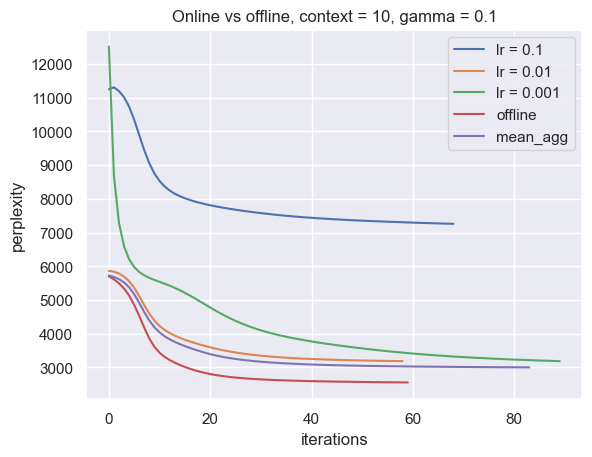

In [47]:
for label, values in perplexities.items():
    plt.plot(values[1:], label=label)

plt.title('Online vs offline, context = 10, gamma = 0.1')
plt.yticks(np.arange(3000, 13000, 1000))
plt.xlabel('iterations')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [22]:
%%time

model = ContextTopicModelDebug(
    ctx_len=10,
    vocab_size=len(dataset.vocab),
    gamma=0.1,
    n_topics=10,
)
model.fit(*dataset.data, verbose=2)
# model.fit(loader, lr=0.1, verbose=2)

phi_hatch: (107671, 10) 0.0
phi_it_hatch: (3414473, 10) 0.0
phi_it_hatch_with_context: (3414473, 21, 10) 0.8
context_matrix: (3414473, 21) 1.0
theta_it: (3414473, 10) 1.6
theta: (3414473, 10) 1.7
phi_it: (3414473, 10) 1.7
n_t: (10,) 1.8
phi_new: (107671, 10) 1.9
Iteration [1/1000], phi update diff norm: 0.1312
phi_hatch: (107671, 10) 0.0
phi_it_hatch: (3414473, 10) 0.0
phi_it_hatch_with_context: (3414473, 21, 10) 0.6
context_matrix: (3414473, 21) 0.8
theta_it: (3414473, 10) 1.4
theta: (3414473, 10) 1.5
phi_it: (3414473, 10) 1.5
n_t: (10,) 1.5
phi_new: (107671, 10) 1.7
Iteration [2/1000], phi update diff norm: 0.0261
phi_hatch: (107671, 10) 0.0
phi_it_hatch: (3414473, 10) 0.0
phi_it_hatch_with_context: (3414473, 21, 10) 0.5
context_matrix: (3414473, 21) 0.7
theta_it: (3414473, 10) 0.9
theta: (3414473, 10) 1.0
phi_it: (3414473, 10) 1.0
n_t: (10,) 1.0
phi_new: (107671, 10) 1.2
Iteration [3/1000], phi update diff norm: 0.0327
phi_hatch: (107671, 10) 0.0
phi_it_hatch: (3414473, 10) 0.0


KeyboardInterrupt: 

In [107]:
# maxlen = 500, context = 10
topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

year	gun	law	government	u	bike	state	israeli	new	american

window	x	use	system	problem	get	need	anyone	drive	file

edu	writes	c	article	subject	apr	cc	news	andrew	uiuc

line	organization	subject	posting	host	nntp	university	distribution	ca	x

one	would	people	think	know	like	time	say	thing	get

thanks	e	please	mail	email	help	advance	p	u	address

com	writes	subject	article	apr	org	gov	netcom	nasa	access

PAD	ryerson	ryevm	keith	sola	employer	acps	tmi	teddy	polytechnical

game	team	player	year	win	last	v	co	play	pitt

PAD	rainer	elin	hochreiter	eeam	keith	excepted	omission	bye	donoghue

